In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# sns.set_theme(style="whitegrid", font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")

products_info = pd.read_csv("/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
districts_info = pd.read_csv("/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")

engagement = pd.DataFrame()

for d_id in districts_info['district_id']:
    df = pd.read_csv("/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/"+f"{d_id}.csv")
    df['district_id'] = d_id
    engagement = pd.concat([engagement, df])

In [2]:
# Preprocessing

# drop 'county_connections_ratio' because all except one district have NaN or the same range
districts_info.drop('county_connections_ratio', axis=1, inplace=True)


# convert range data to one mean value
def make_mean(col):
    df = districts_info.loc[:][col]
    
#     df.apply(lambda x: x.str.replace('[',''))
    
    index = list(df.isna())
    for i in range(len(df)):
        if index[i]:
            continue;
        
        one, two = df[i].split(',')
        df[i] = (float(one) + float(two))/2
    return

cols = ['pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw']

districts_info[cols] = districts_info[cols].apply(lambda x: x.str.replace('[','', regex=True))

for col in cols:
    make_mean(col)

districts_info.fillna(0, inplace=True)


# convert object to datetime for column 'time'
engagement['time'] = pd.to_datetime(engagement['time'])

# merge districts_info into engagement
engagement = engagement.join(districts_info[['district_id','state']].set_index('district_id'), on='district_id')

## *Online learning during pandemic*

During the pandemic, most schools are closed. Some schools have been open, but adapted online learning even on campus to reduce contacts among students and between students and teachers. It is obvious that online learning engagement would be increased in 2020. But even before the school closed, many students had already used online learning. Probably online learning among students has increased as more students have their own devices and wireless connectivity has been improved. Luckily, they were very close to being ready to convert from in-person learning to online learning due to technology development. Then how much impact has pandemic caused on online learning?  


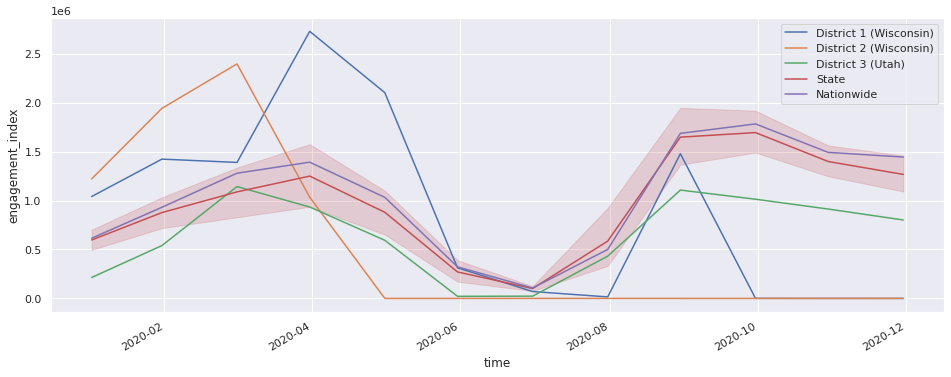

In [3]:
grouped = engagement.drop('lp_id', axis=1).groupby(['state','district_id', pd.Grouper(freq="1M", key='time')]).sum()

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(16,6))

g=sns.lineplot(data=grouped.loc['Wisconsin',7752], x="time", y="engagement_index")
sns.lineplot(data=grouped.loc['Wisconsin',8902], x="time", y="engagement_index")
sns.lineplot(data=grouped.loc['Utah',4921], x="time", y="engagement_index")

sns.lineplot(data=grouped.groupby(['state', 'time']).mean(), x="time", y="engagement_index")
sns.lineplot(data=grouped.groupby('time').mean(), x="time", y="engagement_index")
plt.legend(["District 1 (Wisconsin)", "District 2 (Wisconsin)", "District 3 (Utah)", "State","Nationwide"])

g.set_xticklabels(['2020-02', '2020-04', '2020-06', '2020-08', '2020-10', '2020-12'])
g.figure.autofmt_xdate()
plt.show()

The monthly *engagement_index* shown in the figure explains how many pages were accessed per one thousand students for every month regardless of products. Monthly *engagement_index* in one district may be far from each other, but the state averaged index for each state may not be very far from the national average. In Jan. & Feb. 2020 before the school closing, the *engagement_index* had already an increasing trend. In the middle of the school year, schools had to close their campuses, but they couldn't totally convert classes to an online interactive learning environment. They might try to maximize the usage of online materials rather than adopting new platforms since they didn't have enough time to completely switch to new platforms. 

After the summer break (Jun., Jul., Aug.), the *engagement_index* have definitely increased. The schools and districts had adopted new platforms and created new curriculums for online learning in the new school year. But in Nov. and Dec., the *engagement_index* has been decreased. It may be caused by Thanksgiving and Holidays breaks, or some schools like District 2 (Wisconsin) gave up using online learning platforms. 

The districts in the figure do not follow the increasing trend. The gap between the two districts from one state (Wisconsin) is not negligible. Furthermore, due to the lack of information about districts and insufficient number of districts for each state, it is hard to conclude at state-level or district-level. Then, can we find some trends by products?


## *Which online learning platforms become more popular?*

Online learning has been increased before and after the school closing. Then, has the pandemic changed the way students learn? Does it make any changes on online platform products used for learning? Below shows which products were popular in each month.

In [4]:
engagement = engagement.join(products_info[['LP ID','Product Name','Primary Essential Function']].set_index('LP ID'), on='lp_id', how='inner')
grouped_lp = engagement.drop('lp_id', axis=1).groupby(['state','district_id', pd.Grouper(freq="1M", key='time'),'Product Name']).mean()
grouped_lp = grouped_lp.groupby(['time','Product Name']).mean()
grouped_lp = grouped_lp.sort_values(by=['time', 'pct_access'], ascending=[True, False])

In [5]:
months = ['2020-01','2020-02', '2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12']

df = pd.DataFrame(columns=months)

n = 12

for m in months:
    df[m] = grouped_lp.loc[m][:n].index.droplevel(0)
    
df

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,Google Docs,Google Docs,Google Docs,Google Classroom,Google Classroom,Google Classroom,YouTube,Google Docs,Google Docs,Google Docs,Google Classroom,Google Classroom
1,Google Classroom,Google Classroom,Google Classroom,Google Docs,Google Docs,Google Docs,Google Docs,Google Classroom,Google Classroom,Google Classroom,Google Docs,Google Docs
2,Google Drive,Google Drive,Google Drive,Google Drive,Google Drive,YouTube,Google Classroom,YouTube,YouTube,YouTube,YouTube,YouTube
3,Clever,Clever,Google Forms,Google Forms,Google Forms,Google Drive,ClassLink,Google Drive,Google Drive,Google Forms,Meet,Meet
4,Google Sites,Google Sites,Clever,Meet,Meet,Meet,Google Drive,Canvas,Google Forms,Google Drive,Zoom,Zoom
5,Google Forms,Canvas,Canvas,Canvas,Clever,Google Forms,Securly Anywhere Filter,Zoom,Zoom,Meet,Google Forms,Google Forms
6,Canvas,Google Forms,Google Sites,Clever,Canvas,ClassLink,Meet,Google Forms,Meet,Zoom,Google Drive,Google Drive
7,i-Ready,ClassLink,Meet,Zoom,Zoom,Zoom,Clever,Clever,Canvas,Canvas,Canvas,Canvas
8,ClassLink,Quizlet,ClassLink,Google Sites,Google Sites,Clever,Zoom,Meet,Clever,Clever,Clever,Clever
9,Quizlet,Securly Anywhere Filter,Quizlet,ClassLink,ClassLink,Google Sites,Netflix,ClassLink,ClassLink,ClassLink,ClassLink,ClassLink


Before the school closing (Jan. & Feb.), the most popular learning systems were **Google products**. After the closing, still Google products are placed in high ranks, but **Zoom** became obviously more popular. During the summer break, **YouTube** became popular, but then even after the new school started, YouTube took a high rank. Schools might start to use various useful and fun video resources for education purposes, or students started to utilize the devices for their own fun. Students have a lot of freedom from teachers' observance during online learning, and some of them easily lose their self-control and could not resist from watching fun videos on their devices. **Schoology** might be adapted as one of the main learning platforms in the new year. **Epic!** definitely is a good source for kids to spend their time since libraries had limited hours or were closed. **Seesaw** became to be used for homework assignments.  



In [6]:
products = []

for i in range(n):
    products = products + list(pd.Series(df.loc[i]))

products = list(set(products))
print("The frequently used products: ",products)

The frequently used products:  ['Canvas', 'Schoology', 'Flipgrid', 'Google Sites', 'Zoom', 'Edpuzzle', 'Khan Academy', 'ClassLink', 'Google Forms', 'YouTube', 'Clever', 'Google Classroom', 'Meet', 'Google Docs', 'Google Drive', 'i-Ready', 'Kahoot!', 'Quizlet', 'Netflix', 'Securly Anywhere Filter']


In [7]:
grouped_lp_time = engagement.drop('lp_id', axis=1).groupby(['state','district_id', pd.Grouper(freq="1M", key='time'),'Product Name']).mean()
grouped_lp_time = grouped_lp_time.groupby(['Product Name','time']).mean()

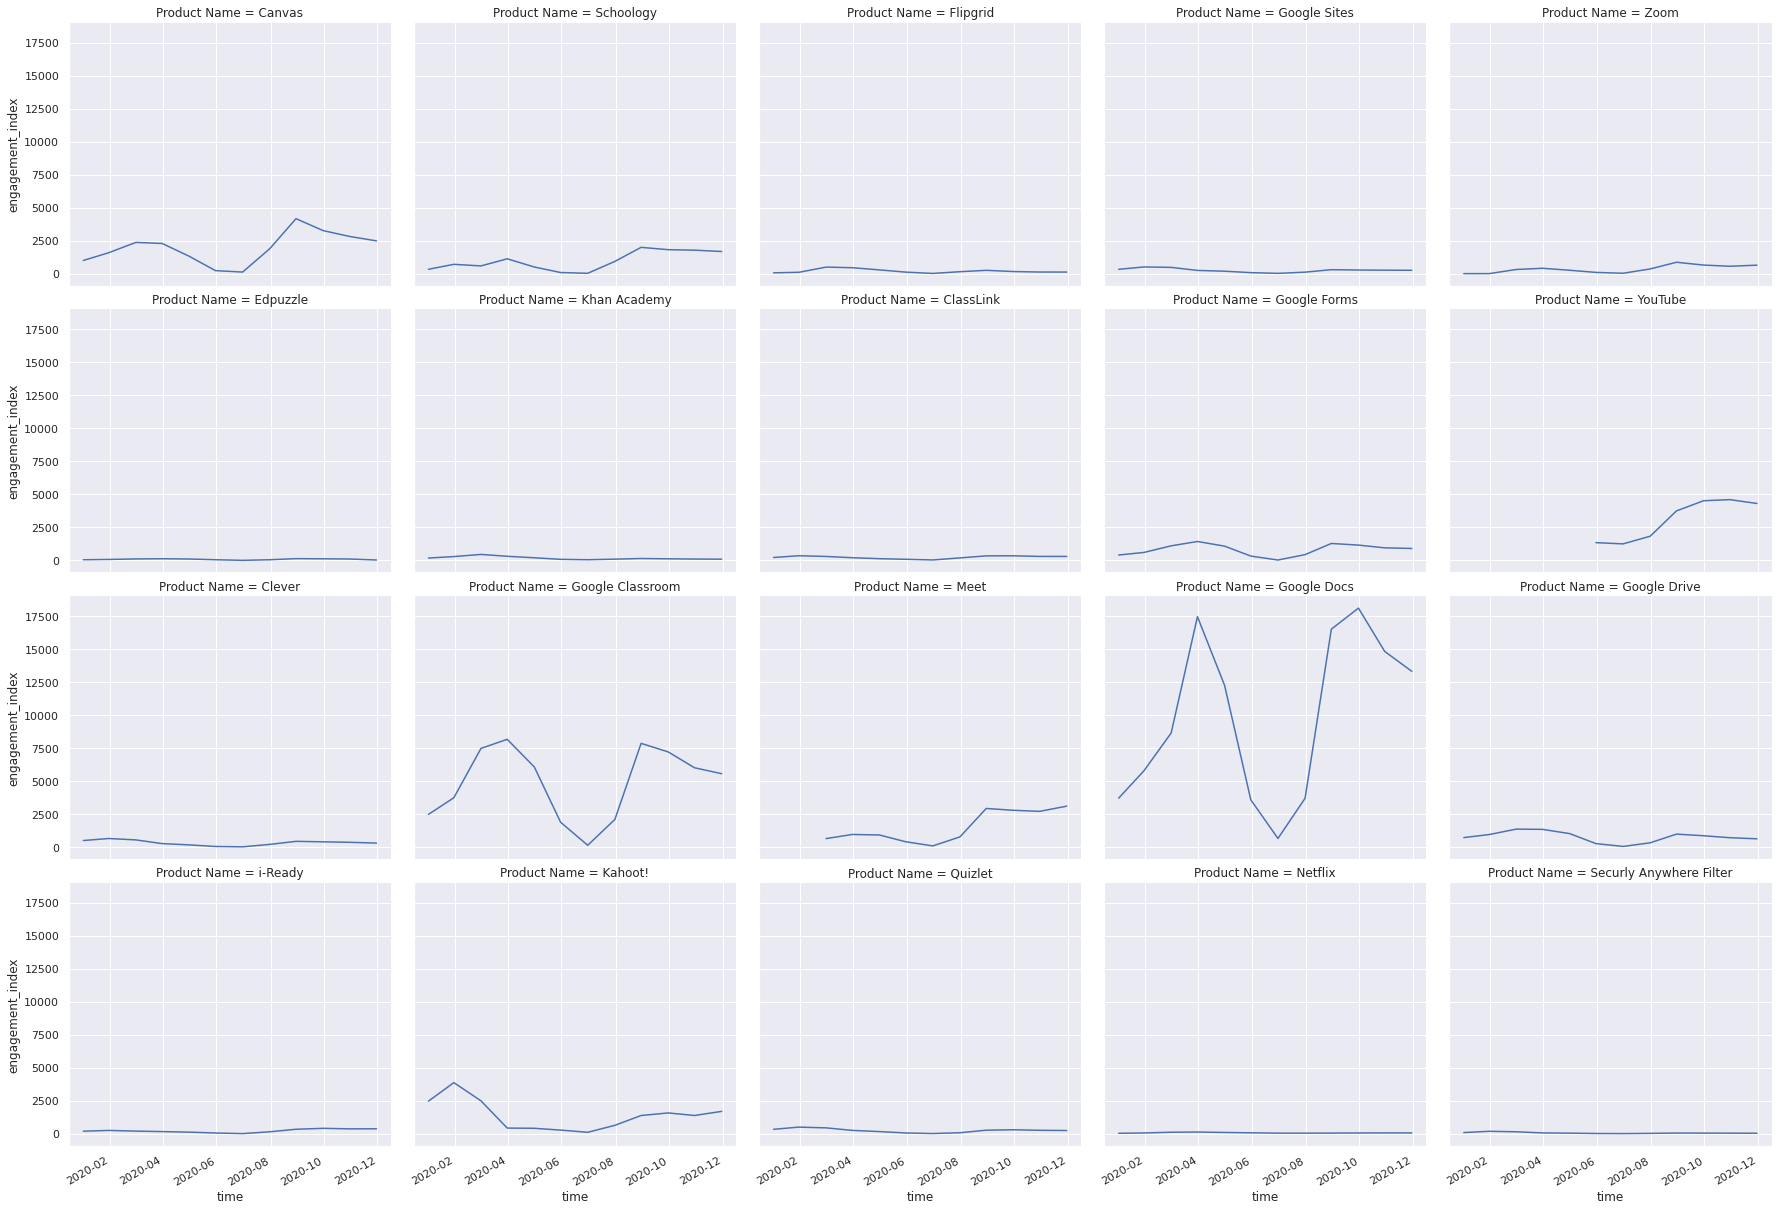

In [8]:
g = sns.relplot(data=grouped_lp_time.loc[products], x='time', y='engagement_index', kind='line', col='Product Name', col_wrap=5)
g.set_xticklabels(['2020-02', '2020-04', '2020-06', '2020-08', '2020-10', '2020-12'])
g.figure.autofmt_xdate()

In terms of the number of pages opened daily per district, *engagement_index*, **Kahoot!**, **Flipgrid** and **Quizlet** are slightly less popular in the new year. That might be because more platforms were created and prepared to be used.

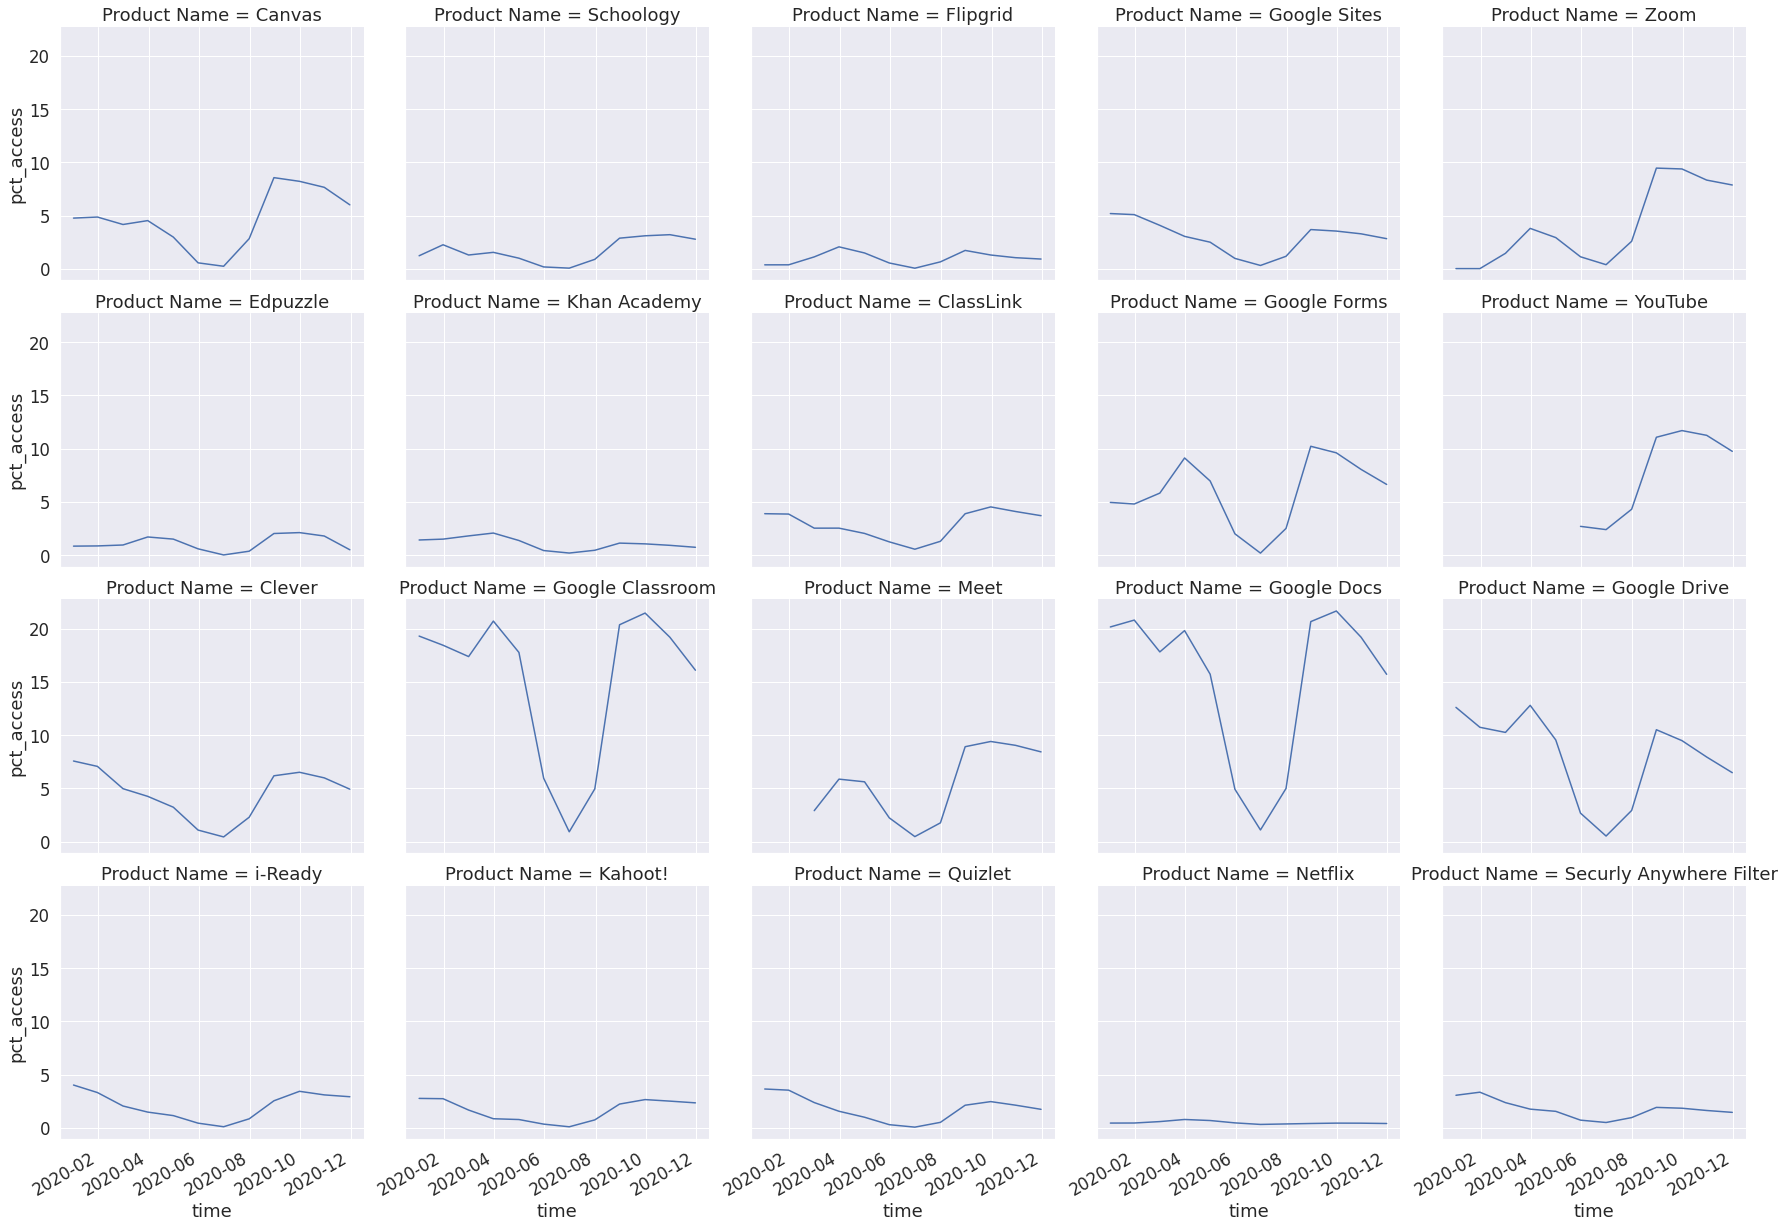

In [9]:
sns.set(font_scale=1.5)
g=sns.relplot(data=grouped_lp_time.loc[products], x='time', y='pct_access', kind='line', col='Product Name', col_wrap=5)

g.set_xticklabels(['2020-02', '2020-04', '2020-06', '2020-08', '2020-10', '2020-12'])
g.figure.autofmt_xdate()

The *pct_access*, the percentage of students who accessed to a certain product in a day, shows that **Google Docs** and **Google Classroom** are the most popular platforms except during the summer break. But even though they have high usages, they still reach only 20% students daily usage. Weekends and no school days definitely affect the percentage, but still 20% is much lower than expected. 

As mentioned before, **YouTube** came up in the new school year, and **Zoom** and **Meet** have become much more popular. It seems that schools have utilized video resources and interactive video conferencing systems as an effort to imitate face-to-face teaching rather than text-based self-learning. 

Below are the averaged *pct_access* and *engagement_index* of each platform except Google products.


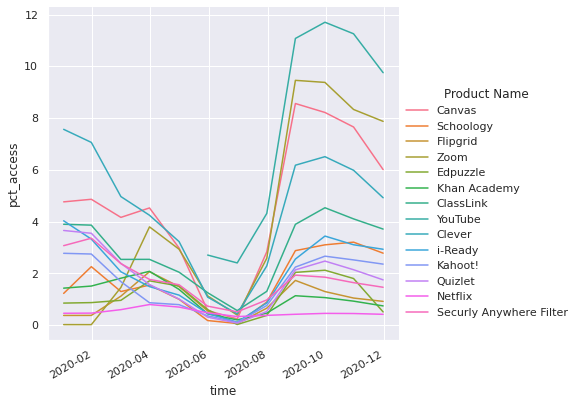

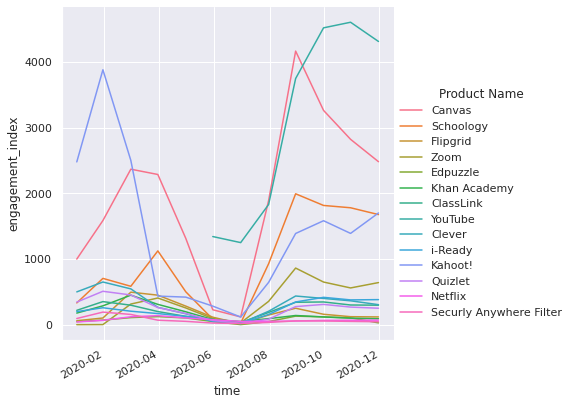

In [10]:
import re

pattern = re.compile("Google[\s\w*]")

no_google_products = []

for product in products:
    if not pattern.match(product):
        no_google_products.append(product)

no_google_products.remove('Meet')

sns.set(font_scale=1)
g=sns.relplot(data=grouped_lp_time.loc[no_google_products], x='time', y='pct_access', kind='line', hue='Product Name', height=6)
g.set_xticklabels(['2020-02', '2020-04', '2020-06', '2020-08', '2020-10', '2020-12'])
g.figure.autofmt_xdate()
plt.show()


g=sns.relplot(data=grouped_lp_time.loc[no_google_products], x='time', y='engagement_index', kind='line', hue='Product Name', height=6)
g.set_xticklabels(['2020-02', '2020-04', '2020-06', '2020-08', '2020-10', '2020-12'])
g.figure.autofmt_xdate()
plt.show()

Definitely, Google products are big hits. There can be many reasons. From one account, students can access Meet, Docs, Forms, Sites, and Classroom. Google products help to achieve both accessibility and compatibility. Except that, the data prove migration from text-based learning through online resources to interactive learning through video conferencing as well as online text and video resources. 

What will be a trend for the future? We are getting used to reading from devices and talking through devices, and do not want to waste time in a car. Schools are open now and back to face-to-face learning, but some people may say that they prefer online learning since it is convenient and timesaving. 
